In [1]:
!pip -q install datasets sentence-transformers scikit-learn numpy

In [2]:
import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression

In [3]:
rng = np.random.default_rng(42)

In [4]:
# loading datasets
src = load_dataset("fancyzhx/amazon_polarity")  # source domain (labelled)
tgt = load_dataset("fancyzhx/yelp_polarity")    # target domain (unlabelled)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [6]:
# Sample manageable subset
src_idx = rng.choice(len(src["train"]), 8000, replace=False)
tgt_idx = rng.choice(len(tgt["train"]), 12000, replace=False)

Xs = [(src["train"][int(i)]["title"] + " " + src["train"][int(i)]["content"]).strip() for i in src_idx]
ys = np.array([src["train"][int(i)]["label"] for i in src_idx], int)

Xt = [tgt["train"][int(i)]["text"] for i in tgt_idx]

In [7]:
# Target labeled test set (ONLY for final evaluation)
Xt_test = [tgt["test"][i]["text"] for i in range(5000)]
yt_test = np.array([tgt["test"][i]["label"] for i in range(5000)], int)

In [8]:
# source keyword selection + labelling

vsrc = CountVectorizer(stop_words="english", min_df=5, max_features=60000)
Xsrc = vsrc.fit_transform(Xs)

# Chi-square feature importance
scores, _ = chi2(Xsrc, ys)
top = np.argsort(-scores)[:4000]
words = np.array(vsrc.get_feature_names_out())[top]

# Determine polarity by comparing frequency in pos vs neg docs
pos_freq = Xsrc[ys == 1].sum(0).A1 + 1
neg_freq = Xsrc[ys == 0].sum(0).A1 + 1
src_lab = {w: int(pos_freq[vsrc.vocabulary_[w]] > neg_freq[vsrc.vocabulary_[w]]) for w in words}

In [9]:
# target keyword selection + labelling using embeddings

vtgt = CountVectorizer(stop_words="english", min_df=5, max_features=60000)
XtX = vtgt.fit_transform(Xt)

# Select frequent target words
twords = np.array(vtgt.get_feature_names_out())[np.argsort(-XtX.sum(0).A1)[:4000]]

# Load pretrained embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Seed sentiment words
pos_seeds = ["good","great","excellent","awesome","amazing","love","perfect"]
neg_seeds = ["bad","terrible","awful","disappointing","hate","worst","poor"]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# Encode words and seeds
Ew = model.encode(twords.tolist(), normalize_embeddings=True)
Ep = model.encode(pos_seeds, normalize_embeddings=True)
En = model.encode(neg_seeds, normalize_embeddings=True)

# Compute cosine similarity
pbest = (Ew @ Ep.T).max(1)
nbest = (Ew @ En.T).max(1)

In [11]:
# Assign label if confidently closer to one polarity
tgt_lab = {w: 1 for w, ps, ns in zip(twords, pbest, nbest) if ps - ns >= 0.05}
tgt_lab |= {w: 0 for w, ps, ns in zip(twords, pbest, nbest) if ns - ps >= 0.05}

In [12]:
# find common words with same label
common = [w for w in src_lab if w in tgt_lab and src_lab[w] == tgt_lab[w]]

In [13]:
# training first classifier on source data using common keywords as features
vc = CountVectorizer(stop_words="english", vocabulary=common)
clf1 = LogisticRegression(max_iter=1000).fit(vc.fit_transform(Xs), ys)

In [14]:
#pseudo-label target data with high confidence
p1 = clf1.predict_proba(vc.transform(Xt))
keep = np.max(p1, 1) >= 0.90

Xp = [Xt[i] for i in np.where(keep)[0]]
yp = np.argmax(p1[keep], 1)

In [15]:
# training second classifier (target-domain) on pseudo-labelled target data
vf = CountVectorizer(stop_words="english", min_df=2, max_features=80000).fit(Xs + Xt)
clf2 = LogisticRegression(max_iter=1000).fit(vf.transform(Xp), yp)

In [16]:
# ensemble classifier-3 + one refinement step
w1, w2 = 0.5, 0.5
p = w1 * clf1.predict_proba(vc.transform(Xt)) + w2 * clf2.predict_proba(vf.transform(Xt))
keep2 = np.max(p, 1) >= 0.90

Xp2 = Xp + [Xt[i] for i in np.where(keep2)[0]]
yp2 = np.concatenate([yp, np.argmax(p[keep2], 1)])

clf2.fit(vf.transform(Xp2), yp2)  # final target classifier

LogisticRegression(max_iter=1000)

In [17]:
# evaluation on labelled target test data
acc = (clf2.predict(vf.transform(Xt_test)) == yt_test).mean()
print("Common words:", len(common),
      "| pseudo-labeled:", len(yp2),
      "| target test accuracy:", round(float(acc), 4))

Common words: 564 | pseudo-labeled: 11934 | target test accuracy: 0.8068


In [19]:
#inference

import numpy as np

# Take 10 samples from labeled target test set
idx = np.random.choice(len(Xt_test), 10, replace=False)
samples = [Xt_test[i] for i in idx]
true_labels = yt_test[idx]

# Predict using final target-domain classifier (clf2)
proba = clf2.predict_proba(vf.transform(samples))
pred_labels = np.argmax(proba, axis=1)
conf = np.max(proba, axis=1)

for i, (text, true, pred, c) in enumerate(zip(samples, true_labels, pred_labels, conf), 1):
    true_str = "POS" if true == 1 else "NEG"
    pred_str = "POS" if pred == 1 else "NEG"

    print(f"\n{i}. ACTUAL: {true_str} | PRED: {pred_str} | conf={c:.3f}")
    print(text[:220] + ("..." if len(text) > 220 else ""))


1. ACTUAL: NEG | PRED: NEG | conf=0.895
-An acceptable chain restaurant to take \""out-of-town\"" visitors for (overpriced) sit down Mexican food with tacky decor.\n\n-Expensive! Almost $11 bucks for a carne asada burrito???? Really?? For that price, I could h...

2. ACTUAL: POS | PRED: POS | conf=0.999
I don't know what I would do without Sally's! I love the professional hair and nail products they offer to the general public that you can't find at Ulta or similar stores. They carry profesional hair color brands such a...

3. ACTUAL: POS | PRED: POS | conf=1.000
Hubby and I were so incredibly happy when we saw that there's a place on the Mainland that has Meat Jun.  We were so excited to try it out and this place did not disappoint.  The Meat Jun is just as good as in Oahu.  For...

4. ACTUAL: POS | PRED: POS | conf=0.959
4 legged friends gets 10 stars. Dr. Ferguson and all her fantastic associates are outstanding individuals. I have been going there a very long time and they continu

In [20]:
# Baseline vs Patent-style comparison on the SAME target test set
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


tgt = load_dataset("fancyzhx/yelp_polarity")


N_TRAIN = 20000
train_texts = [tgt["train"][i]["text"] for i in range(N_TRAIN)]
train_labels = np.array([tgt["train"][i]["label"] for i in range(N_TRAIN)], dtype=int)


v_base = CountVectorizer(stop_words="english", min_df=2, max_features=80000)
Xtr = v_base.fit_transform(train_texts)
clf_base = LogisticRegression(max_iter=1000).fit(Xtr, train_labels)

acc_base = (clf_base.predict(v_base.transform(Xt_test)) == yt_test).mean()


acc_patent = (clf2.predict(vf.transform(Xt_test)) == yt_test).mean()

print("Traditional (target-only supervised) accuracy:", round(float(acc_base), 4))
print("Patent-style (source + target unlabeled) accuracy:", round(float(acc_patent), 4))
print("Gap (patent - traditional):", round(float(acc_patent - acc_base), 4))

Traditional (target-only supervised) accuracy: 0.8954
Patent-style (source + target unlabeled) accuracy: 0.8068
Gap (patent - traditional): -0.0886


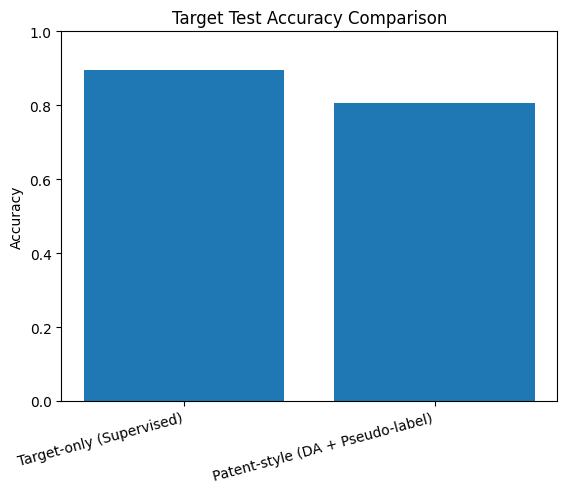

In [21]:
import matplotlib.pyplot as plt

methods = ["Target-only (Supervised)", "Patent-style (DA + Pseudo-label)"]
accs = [acc_base, acc_patent]

plt.figure()
plt.bar(methods, accs)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Target Test Accuracy Comparison")
plt.xticks(rotation=15, ha="right")
plt.show()

<Figure size 640x480 with 0 Axes>

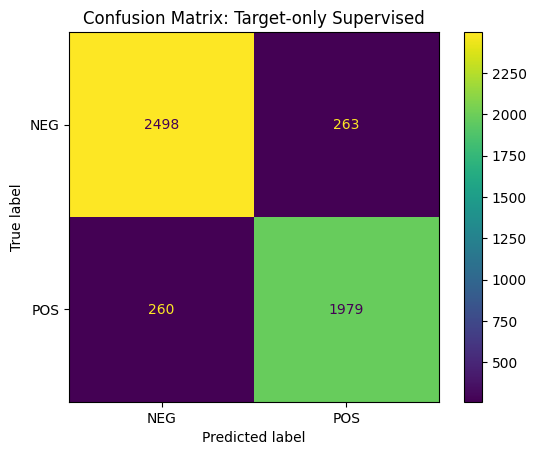

<Figure size 640x480 with 0 Axes>

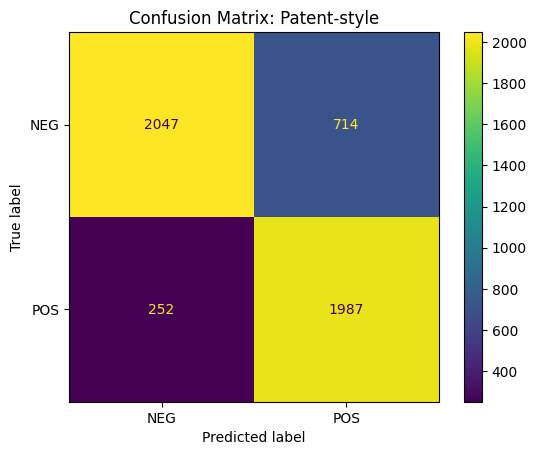

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Baseline predictions
yhat_base = clf_base.predict(v_base.transform(Xt_test))

# Patent-style predictions
yhat_pat = clf2.predict(vf.transform(Xt_test))

plt.figure()
ConfusionMatrixDisplay(confusion_matrix(yt_test, yhat_base), display_labels=["NEG","POS"]).plot(values_format="d")
plt.title("Confusion Matrix: Target-only Supervised")
plt.show()

plt.figure()
ConfusionMatrixDisplay(confusion_matrix(yt_test, yhat_pat), display_labels=["NEG","POS"]).plot(values_format="d")
plt.title("Confusion Matrix: Patent-style")
plt.show()

patent method (no target labels) performs like having ~X labeled target samples

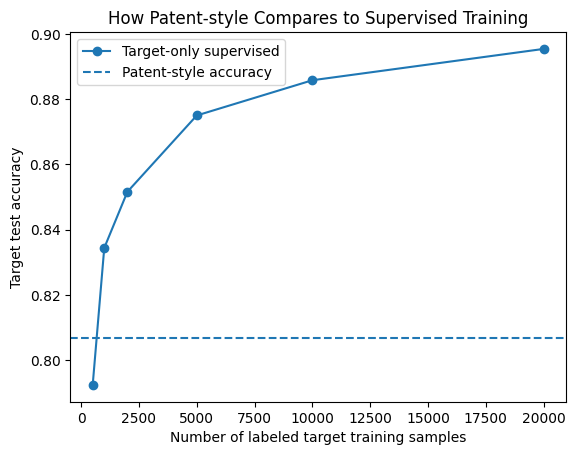

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

train_sizes = [500, 1000, 2000, 5000, 10000, 20000]
acc_curve = []

for n in train_sizes:
    Xtr = v_base.fit_transform(train_texts[:n])
    clf_tmp = LogisticRegression(max_iter=1000).fit(Xtr, train_labels[:n])
    acc_n = (clf_tmp.predict(v_base.transform(Xt_test)) == yt_test).mean()
    acc_curve.append(acc_n)

plt.figure()
plt.plot(train_sizes, acc_curve, marker="o", label="Target-only supervised")
plt.axhline(acc_patent, linestyle="--", label="Patent-style accuracy")
plt.xlabel("Number of labeled target training samples")
plt.ylabel("Target test accuracy")
plt.title("How Patent-style Compares to Supervised Training")
plt.legend()
plt.show()